# NEURAL NETWORKS FOR TIME SERIES CLASSIFICATION

Welcome to our series about time series classification. In this series we want to show how data, e.g. from sensors, can be analyzed using machine learning and AI (Artificial Intelligence) techniques.

Time series classification is a possible starting point to get an idea how complex applications in practice can be approached using AI. Such applications are for example anomaly detection, remaining useful life estimation, predictive maintenance, etc.

## What is time series classification?

Time series can be measurements of signals like temperature, pressure, voltage, etc. These signals can be univariate or multivariate data. Usually, the data consist of of
*K* (e.g. *K=6*) different classes. And here's the key question:

*Can we find a function that predicts the class for a new, unknown measurement data signal?*

For a formal definition, the interested reader may be referred to (Fawaz et al. 2019). There are different approaches to get such a function. In this blog we want to focus on the approach known as neural networks for classification. The interested reader may refer to (Fawaz et al. 2019) to get more information about this topic.

Let's import some standard libraries:

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import tensorflow as tf
import urllib.request
import zipfile

print(tf.__version__)
print(tf.keras.__version__)

2.9.1
2.9.0


In [2]:
# download
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
urllib.request.urlretrieve(url, "HAR_Dataset.zip")

('HAR_Dataset.zip', <http.client.HTTPMessage at 0x23e4be07130>)

In [3]:
# unzip
with zipfile.ZipFile("./HAR_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(path=".")

A help function - do not edit

In [4]:
def read_uci_har_data(start_path):
    X_train, X_test, = [], []
    # read the train signal data
    for input_file in os.listdir(start_path + '/UCI HAR Dataset/train/Inertial Signals'):
        my_signal = pd.read_csv(start_path + '/UCI HAR Dataset/train/Inertial Signals/' + input_file, header=None, delim_whitespace=True)
        X_train.append(my_signal.to_numpy())
    X_train = np.transpose(np.array(X_train), (1, 2, 0))
    # read the test signal data
    for input_file in os.listdir(start_path + '/UCI HAR Dataset/test/Inertial Signals/'):
        my_signal = pd.read_csv(start_path + '/UCI HAR Dataset/test/Inertial Signals/' + input_file, header=None, delim_whitespace=True)
        X_test.append(my_signal.to_numpy())
    X_test = np.transpose(np.array(X_test), (1, 2, 0))
    # read the labels
    y_train = pd.read_csv(start_path + '/UCI HAR Dataset/train/y_train.txt', header=None).to_numpy()
    y_test = pd.read_csv(start_path + '/UCI HAR Dataset/test/y_test.txt', header=None).to_numpy()
    return X_train, X_test,y_train,y_test

In [5]:
X_train, X_test,y_train,y_test = read_uci_har_data(".")
print(X_train.shape)  # should be (7352, 128, 9)
print(y_train.shape)  # should be (7352,1)

(7352, 128, 9)
(7352, 1)


Transform the multivariate time series to a univariate time series - run only once!

In [6]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]),order='F')
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]),order='F')
print(X_train.shape) # should be (7352, 1152)
print(X_train[0].mean()) # should be 0.11537594842792709
print(X_train[0].std()) # should be 0.3243178451795317

(7352, 1152)
0.11537594842792709
0.3243178451795317


Normalize to mean 0 and standard deviation 1 - run only once!

In [7]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape) # should be (7352, 1152) again
# should be exactly 0 and 1
print(X_train.mean()) # should be (exactly) 0
print(X_train.std()) # should be (exactly) 1
# should be around 0 and 1
print(X_test.mean()) # should be -0.00713964303801565 (i.e. around but not exactly 0)
print(X_test.std()) # should be 0.9540409710015257 (i.e. around but not exactly 1)

(7352, 1152)
5.973271018718349e-19
1.0000000000000002
-0.00713964303801565
0.9540409710015257


The labels must be a one dimensional vector starting by 0 - run only once!

In [8]:
print('Before:')
print(y_train.min()) # should be 1
print(y_train.max()) # should be 6
# labels must be integers starting by 0
y_train = y_train-1
# labels must be converted to 1-dimensional row vector
y_train = y_train.flatten()
print('After:')
print(y_train.min()) # should be 0
print(y_train.max()) # should be 5
# same procedure for the test data
y_test = y_test-1
# labels must be converted to 1-dimensional row vector
y_test = y_test.flatten()

Before:
1
6
After:
0
5


## DEFINING THE MODEL WITH TENSORFLOW

In [9]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation='sigmoid'),  # 32: number of hidden neurons
  tf.keras.layers.Dense(6, activation='sigmoid')    # 6: classes to predict
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## COMPILE THE MODEL

In [10]:
model1.compile(optimizer='adam',     # adam: standard optimization method
              loss=loss_fn,          # loss function: as defined above
              metrics=['accuracy'])

## Train the model

In [11]:
history1=model1.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20,verbose=2)

Epoch 1/20


C:\Users\schroth\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


230/230 - 1s - loss: 0.9845 - accuracy: 0.6869 - val_loss: 0.9060 - val_accuracy: 0.7313 - 973ms/epoch - 4ms/step
Epoch 2/20
230/230 - 0s - loss: 0.6320 - accuracy: 0.8494 - val_loss: 0.7568 - val_accuracy: 0.7967 - 408ms/epoch - 2ms/step
Epoch 3/20
230/230 - 0s - loss: 0.4733 - accuracy: 0.8980 - val_loss: 0.6804 - val_accuracy: 0.8191 - 357ms/epoch - 2ms/step
Epoch 4/20
230/230 - 0s - loss: 0.3759 - accuracy: 0.9168 - val_loss: 0.6254 - val_accuracy: 0.8249 - 380ms/epoch - 2ms/step
Epoch 5/20
230/230 - 0s - loss: 0.3105 - accuracy: 0.9306 - val_loss: 0.5885 - val_accuracy: 0.8344 - 363ms/epoch - 2ms/step
Epoch 6/20
230/230 - 0s - loss: 0.2648 - accuracy: 0.9369 - val_loss: 0.5646 - val_accuracy: 0.8442 - 497ms/epoch - 2ms/step
Epoch 7/20
230/230 - 0s - loss: 0.2333 - accuracy: 0.9414 - val_loss: 0.5411 - val_accuracy: 0.8470 - 358ms/epoch - 2ms/step
Epoch 8/20
230/230 - 0s - loss: 0.2092 - accuracy: 0.9455 - val_loss: 0.5316 - val_accuracy: 0.8432 - 352ms/epoch - 2ms/step
Epoch 9/20


Plot the results

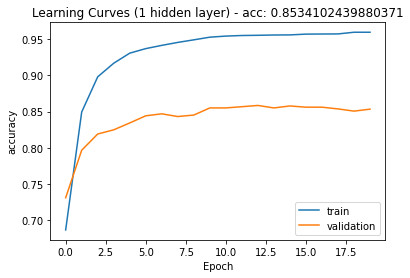

In [12]:
plt.title('Learning Curves (1 hidden layer) - acc: ' + str(history1.history['val_accuracy'][-1]))
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

## Defining a 2nd model with two layers:

In [13]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='sigmoid'),  # 64/256: number of hidden neurons (1st layer)
    tf.keras.layers.Dense(32, activation='sigmoid'),  # 32/256: number of hidden neurons (2nd layer)
    tf.keras.layers.Dense(6, activation='sigmoid')    # 6: 6 classes to predict

])

Compile the 2nd model:

In [14]:
model2.compile(optimizer='Adam',
              loss=loss_fn,
              metrics=['accuracy'])


## Train the 2nd model:

In [15]:
history2=model2.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20,verbose=2)

Epoch 1/30
230/230 - 1s - loss: 1.2771 - accuracy: 0.5306 - val_loss: 1.1208 - val_accuracy: 0.5796 - 956ms/epoch - 4ms/step
Epoch 2/30
230/230 - 0s - loss: 0.8410 - accuracy: 0.7437 - val_loss: 0.8966 - val_accuracy: 0.7099 - 436ms/epoch - 2ms/step
Epoch 3/30
230/230 - 0s - loss: 0.5530 - accuracy: 0.8765 - val_loss: 0.6763 - val_accuracy: 0.8168 - 401ms/epoch - 2ms/step
Epoch 4/30
230/230 - 0s - loss: 0.3597 - accuracy: 0.9260 - val_loss: 0.5716 - val_accuracy: 0.8497 - 411ms/epoch - 2ms/step
Epoch 5/30
230/230 - 0s - loss: 0.2481 - accuracy: 0.9437 - val_loss: 0.5000 - val_accuracy: 0.8602 - 453ms/epoch - 2ms/step
Epoch 6/30
230/230 - 0s - loss: 0.1897 - accuracy: 0.9490 - val_loss: 0.4756 - val_accuracy: 0.8588 - 442ms/epoch - 2ms/step
Epoch 7/30
230/230 - 0s - loss: 0.1570 - accuracy: 0.9531 - val_loss: 0.4623 - val_accuracy: 0.8612 - 413ms/epoch - 2ms/step
Epoch 8/30
230/230 - 0s - loss: 0.1360 - accuracy: 0.9563 - val_loss: 0.4521 - val_accuracy: 0.8660 - 427ms/epoch - 2ms/step


Plot the results:

93/93 - 0s - loss: 0.6500 - accuracy: 0.8633 - 104ms/epoch - 1ms/step


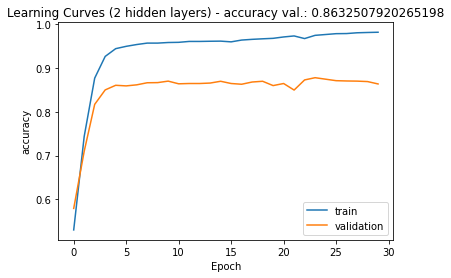

In [16]:
plt.title('Learning Curves (2 hidden layers) - accuracy val.: ' + str(model2.evaluate(X_test,  y_test, verbose=2)[1]))
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.show();